In [5]:
import os

import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)

import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv('../data_source/train.csv', encoding='unicode_escape')
test = pd.read_csv('../data_source/test.csv', encoding='unicode_escape')

display(train.head(2))
display(test.head(2))

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105


,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0


In [7]:
sentiment_label = {
    'neutral': 1, 
    'negative': 0, 
    'positive': 2
}

In [8]:
# train has one missing item in text and selected text
# test has 1281 rows with all missing values
print(train.isnull().sum())
print(test.isnull().sum())

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64
textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64


In [9]:
train = train[['text', 'sentiment']].dropna()
train['sentiment'] = train['sentiment'].apply(lambda x: sentiment_label[x])

test = test[['text', 'sentiment']].dropna()
test['sentiment'] = test['sentiment'].apply(lambda x: sentiment_label[x])

sentiment
1    0.404549
2    0.312300
0    0.283151
Name: proportion, dtype: float64


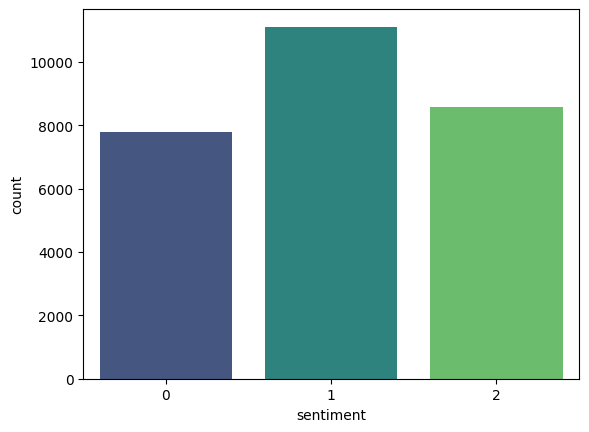

sentiment
1    0.404641
2    0.312111
0    0.283248
Name: proportion, dtype: float64


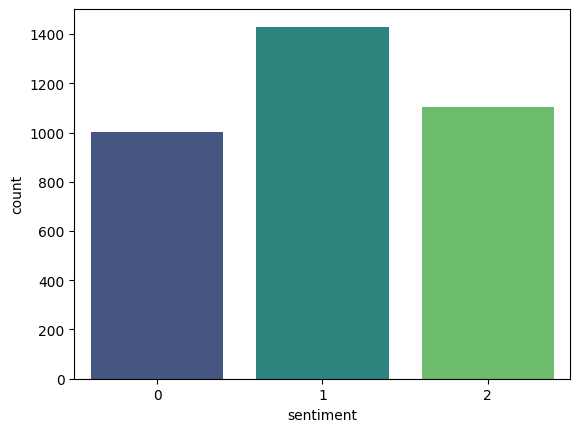

In [10]:
## distribution of classes to predict for classification is uniform in train and test set
print(train['sentiment'].value_counts(normalize=True))
sns.countplot(x='sentiment', data=train, palette='viridis')
plt.show()

print(test['sentiment'].value_counts(normalize=True))
sns.countplot(x='sentiment', data=test, palette='viridis')
plt.show()

In [11]:
# Defining language models and tokenizer to be used for text classification 
model_ckpt = 'distilbert/distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_ckpt, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_ckpt, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# splitting the train data in train and validation data, so as to have evaluation metrics while training
train_text, val_text, train_labels, val_labels = train_test_split(train['text'], train['sentiment'], test_size=0.2, random_state=42, shuffle=True)

In [13]:
def make_dataset(data_encodings):
    """ function to make our non-[torchDataset, Dataloader batches or dataset'sDataset],
      compatible with data input requirements(every item being a dict with 'input_ids' and 'labels') in the Trainer."""
    
    return [{k:v[i] for k,v in data_encodings.items()} for i in range(len(data_encodings['input_ids']))]

In [14]:
#tokenizing data and preparing them for training input
tokenized_train = tokenizer(train_text.tolist(), padding=True, truncation=True, return_tensors='pt')
tokenized_train['labels'] = torch.tensor(train_labels.to_list())
tokenized_train = make_dataset(tokenized_train)   # not a torch.utils.data.Dataset but will work because every element of this list object is a dict like Dataset 

tokenized_val = tokenizer(val_text.to_list(), padding=True, truncation=True, return_tensors='pt')
tokenized_val['labels'] = torch.tensor(val_labels.to_list())
tokenized_val = make_dataset(tokenized_val)

tokenized_test = tokenizer(test['text'].to_list(), padding=True, truncation=True, return_tensors='pt')
tokenized_test['labels'] = torch.tensor(test['sentiment'].to_list())
tokenized_test = make_dataset(tokenized_test)


In [15]:
def compute_metrics(p):
    """ compute_metrics to be passed in transformers's Trainer for evaluation while training."""

    pred, labels = p
    pred = np.argmax(pred,axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')

    return {'accuracy': accuracy, 'f1_score': f1}

In [16]:
# creating folder for model output and saving, can be done to huggingface-hub too
out_dir = "../model_sent"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [17]:
args = TrainingArguments(output_dir=out_dir,
                        overwrite_output_dir=True,
                        eval_steps=500,
                        evaluation_strategy='steps',
                        per_device_train_batch_size=16,
                        per_device_eval_batch_size=8,
                        weight_decay=0.01,
                        logging_steps=500,
                        logging_strategy='steps',
                        num_train_epochs=1,
                        save_strategy='epoch',
                        save_only_model=True)

trainer = Trainer(model=model,
                   args=args,
                    train_dataset=tokenized_train,
                    eval_dataset=tokenized_val,
                    tokenizer=tokenizer,
                    compute_metrics=compute_metrics)

In [18]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1374 [00:00<?, ?it/s]

{'loss': 0.6437, 'grad_norm': 6.437277317047119, 'learning_rate': 3.1804949053857355e-05, 'epoch': 0.36}


  0%|          | 0/687 [00:00<?, ?it/s]

{'eval_loss': 0.5577526092529297, 'eval_accuracy': 0.7743813682678311, 'eval_f1_score': 0.7728109616457941, 'eval_runtime': 26.3744, 'eval_samples_per_second': 208.384, 'eval_steps_per_second': 26.048, 'epoch': 0.36}
{'loss': 0.5563, 'grad_norm': 5.300483703613281, 'learning_rate': 1.3609898107714703e-05, 'epoch': 0.73}


  0%|          | 0/687 [00:00<?, ?it/s]

{'eval_loss': 0.5185783505439758, 'eval_accuracy': 0.7893013100436681, 'eval_f1_score': 0.7902481584393038, 'eval_runtime': 18.6787, 'eval_samples_per_second': 294.239, 'eval_steps_per_second': 36.78, 'epoch': 0.73}
{'train_runtime': 406.0351, 'train_samples_per_second': 54.143, 'train_steps_per_second': 3.384, 'train_loss': 0.5782833960032012, 'epoch': 1.0}


TrainOutput(global_step=1374, training_loss=0.5782833960032012, metrics={'train_runtime': 406.0351, 'train_samples_per_second': 54.143, 'train_steps_per_second': 3.384, 'total_flos': 625671240036480.0, 'train_loss': 0.5782833960032012, 'epoch': 1.0})

In [19]:
#final ealuation of validation set after training
trainer.evaluate(eval_dataset=tokenized_val)

  0%|          | 0/687 [00:00<?, ?it/s]

{'eval_loss': 0.51003497838974,
 'eval_accuracy': 0.7907569141193596,
 'eval_f1_score': 0.7906987401675222,
 'eval_runtime': 18.7602,
 'eval_samples_per_second': 292.96,
 'eval_steps_per_second': 36.62,
 'epoch': 1.0}

In [20]:
#performance of model on test data
trainer.evaluate(eval_dataset=tokenized_test)

  0%|          | 0/442 [00:00<?, ?it/s]

{'eval_loss': 0.5099822878837585,
 'eval_accuracy': 0.7883418222976797,
 'eval_f1_score': 0.788410273770965,
 'eval_runtime': 12.4748,
 'eval_samples_per_second': 283.291,
 'eval_steps_per_second': 35.431,
 'epoch': 1.0}

In [21]:
# performance on test data with 
output = trainer.predict(tokenized_test).predictions
y_pred = torch.from_numpy(output).softmax(dim=1).argmax(axis=1)
print(f1_score(y_pred=y_pred, y_true=test['sentiment'], average='weighted'))
print(accuracy_score(y_pred=y_pred, y_true=test['sentiment']))

  0%|          | 0/442 [00:00<?, ?it/s]

0.788410273770965
0.7883418222976797
